In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [2]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
from pandas import read_csv

table = read_csv('/Users/davidguzman/Downloads/Quadranti.csv')

Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()

values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1667-365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

(1302, 35) 1302 (1302,)


In [10]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
        model = Sequential()
        model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
        for i in range(hp.Int('layers',1,4)):
            model.add(LSTM(units = hp_units, return_sequences=True))
        model.add(LSTM(units = hp_units, return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )


In [14]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial =5,
    overwrite=True,
    directory = 'dir',
    project_name = 'tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 10, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [15]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

Trial 10 Complete [00h 06m 13s]
val_loss: 0.10666555762290955

Best val_loss So Far: 0.07498919069766999
Total elapsed time: 00h 47m 49s
INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()

Results summary
Results in dir/tune_hypermodel
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 50
layers: 2
learning_rate: 0.0001
batch_size: 64
Score: 0.07498919069766999
Trial summary
Hyperparameters:
units: 30
layers: 2
learning_rate: 0.0001
batch_size: 16
Score: 0.07686851322650909
Trial summary
Hyperparameters:
units: 50
layers: 2
learning_rate: 0.0001
batch_size: 16
Score: 0.08060681968927383
Trial summary
Hyperparameters:
units: 30
layers: 2
learning_rate: 0.001
batch_size: 16
Score: 0.08128337264060974
Trial summary
Hyperparameters:
units: 60
layers: 1
learning_rate: 0.001
batch_size: 32
Score: 0.10512280166149139
Trial summary
Hyperparameters:
units: 50
layers: 2
learning_rate: 0.001
batch_size: 16
Score: 0.10666555762290955
Trial summary
Hyperparameters:
units: 50
layers: 1
learning_rate: 0.01
batch_size: 32
Score: 0.1364109233021736
Trial summary
Hyperparameters:
units: 30
layers: 4
learning_rate: 0.0001
batch_size: 12

In [24]:
model = tuner.get_best_models()[0]
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             11600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 72,251
Trainable params: 72,251
Non-trainable params: 0
_________________________________________________________________


In [25]:
# make a prediction using 2020 (not used for training or validation, and has different dynamics due to covid)
# adding back the data from 2020
Moggio = table.dropna(how="any")
Moggio = Moggio.reset_index()
#scaling and creating the new testing data
values = Moggio.iloc[:,3:].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 365 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(365, 35) 365 (365,)


2022-02-20 16:10:12.773951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 16:10:12.844955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 16:10:13.077359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 16:10:13.331951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 16:10:13.522724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test RMSE: 2.093


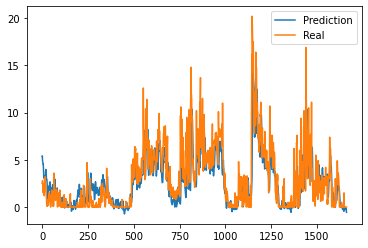

In [26]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()